In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [ ]:
from PIL import Image
from matplotlib import image, pyplot
import pandas as pd
import numpy as np
import joblib
import cv2
import os
import seaborn as sns
from numpy import asarray
import tensorflow as tf
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D,Input,Activation,add,Concatenate ,Dropout
from tensorflow.keras.models import Sequential, Model
from keras import models
from tensorflow.keras.optimizers import Adam, RMSprop, SGD, Nadam
from tensorflow.keras.regularizers import l2,l1
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import recall_score, precision_score, f1_score,confusion_matrix, accuracy_score
from sklearn.utils.class_weight import compute_class_weight
from keras.utils import plot_model
from matplotlib import pyplot as plt
from keras.models import load_model
from tensorflow.keras.models import save_model


### The Dataset

## Problem Staetment
#### This project leverages technology and education to create awareness about plant diseases and empower small-scale farmers in rural Kenya with effective detection and management solutions. A machine learning model using Convolutional Neural Networks (CNNs) will be implemented to detect plant diseases from uploaded images. Farmers will receive real-time diagnoses, treatment recommendations, and access to educational modules on AI-driven pest and disease management.
## Dataset  
#### The dataset I used was a **plant diseases dataset**. It is used to predict and categorize the images based on the disease and class.  
#### https://www.kaggle.com/datasets/puritykihiu/plant-dataset
#### The dataset consists of images of plants, each associated with one of 38 classes representing different plant diseases. The dataset has been split into:

#### Training Set:  56251 images
#### Validation Set: 14044 images
#### Test Set: 654 Images
#### Data Preprocessing
#### Images are resized to 128x128.
#### Data augmentation is applied to improve model generalization.

#### SECTION 1: Model Architecture:

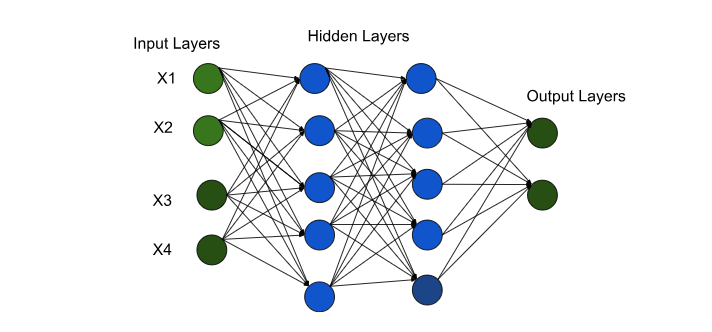

In [ ]:
# Set the path to the plant disease dataset
dataset_path = '/Users/samenergy/Downloads/Plant_Disease_Dataset/'

In [ ]:
# Image settings
IMG_SIZE = (128,128)
BATCH_SIZE = 32

In [ ]:
# Data augmentation and preprocessing
datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2  # 80% training, 20% validation
)


In [ ]:
# Load training data
train_generator = datagen.flow_from_directory(
    os.path.join(dataset_path, 'train'),
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='training'
)

Found 56251 images belonging to 38 classes.


In [ ]:
# Load validation data
validation_generator = datagen.flow_from_directory(
    os.path.join(dataset_path, 'train'),
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation'
)


Found 14044 images belonging to 38 classes.


In [ ]:
test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(
    os.path.join(dataset_path, 'test'),
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)


Found 654 images belonging to 38 classes.


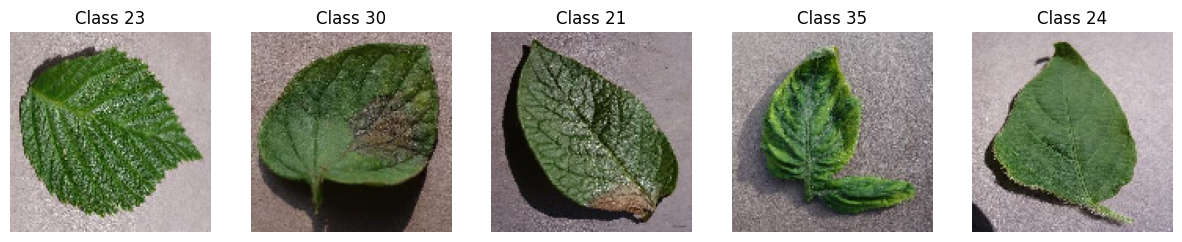

In [ ]:
# Fetch a batch of images and labels
X_batch, y_batch = next(train_generator)

# Define the number of images to display
num_images = 5

# Create a figure to display the images
plt.figure(figsize=(15, 5))

for i in range(num_images):
    image = X_batch[i] * 255
    image = image.astype(np.uint8)

    # Create a subplot for each image
    ax = plt.subplot(1, num_images, i + 1)
    plt.imshow(image)
    plt.axis('off')
    # Display the class label
    plt.title(f"Class {np.argmax(y_batch[i])}")

plt.show()

In [ ]:
def define_model(optimization: str, regularization_datatype, early_stopping: bool, dropout: float, learning_rate: float):
    model = Sequential([
        Conv2D(32, (3, 3), activation='relu', input_shape=(128,128, 3)),
        MaxPooling2D(2, 2),
        Conv2D(64, (3, 3), activation='relu'),
        MaxPooling2D(2, 2),
        Conv2D(64, (3, 3), activation='relu'),
        MaxPooling2D(2, 2),
        Flatten(),
        Dense(64, activation='relu'),
        Dense(train_generator.num_classes, activation='softmax')
    ])
    model.compile(optimizer= optimization,
                 loss='categorical_crossentropy',
                 metrics=['accuracy'])

    return model


In [ ]:
def evaluate_model(model, test_generator, model_name="Model"):
    print(f"\nEvaluating {model_name}...\n")
    _, test_acc = model.evaluate(test_generator, verbose=0)

    y_pred_prob = model.predict(test_generator)
    y_pred_classes = y_pred_prob.argmax(axis=1)

    # Calculate Confusion Matrix
    cm = confusion_matrix(test_generator.classes, y_pred_classes)

    f1 = f1_score(test_generator.classes, y_pred_classes, average='micro')
    recall = recall_score(test_generator.classes, y_pred_classes, average='micro')
    precision = precision_score(test_generator.classes, y_pred_classes, average='micro')

    print(f'{model_name} - Test Accuracy: {test_acc:.3f}, F1 Score: {f1:.4f}, Recall: {recall:.4f}, Precision: {precision:.4f}')

    # Save the model
    model.save(f'{model_name}.keras')
    print(f"Model '{model_name}' saved successfully.")
    print("\nConfusion Matrix:\n", cm)

    # Visualize Confusion Matrix
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Confusion Matrix')
    plt.show()

In [ ]:
def loss_curve_plot(model, history, test_generator, model_name="Model"):
    #  Plot Loss Curve
    epochs = range(1, len(history.history['loss']) + 1)
    plt.figure(figsize=(10, 5))
    plt.plot(epochs, history.history['loss'], 'bo-', label='Training Loss')
    plt.plot(epochs, history.history['val_loss'], 'r*-', label='Validation Loss')
    plt.title(f'{model_name} - Training & Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()


In [ ]:
# Create and train the first model (Adam)
model_1 = define_model('adam', None, False, 0.0, 0.0)
history_1 = model_1.fit(train_generator,
                        validation_data=validation_generator,
                        epochs=10);


Epoch 1/10
1758/1758 ━━━━━━━━━━━━━━━━━━━━ 161s 91ms/step - accuracy: 0.4670 - loss: 1.9089 - val_accuracy: 0.7430 - val_loss: 0.8253
Epoch 2/10
1758/1758 ━━━━━━━━━━━━━━━━━━━━ 158s 90ms/step - accuracy: 0.8452 - loss: 0.4851 - val_accuracy: 0.8484 - val_loss: 0.4857
Epoch 3/10
1758/1758 ━━━━━━━━━━━━━━━━━━━━ 158s 90ms/step - accuracy: 0.9107 - loss: 0.2835 - val_accuracy: 0.8815 - val_loss: 0.3742
Epoch 4/10
1758/1758 ━━━━━━━━━━━━━━━━━━━━ 158s 90ms/step - accuracy: 0.9371 - loss: 0.1920 - val_accuracy: 0.8881 - val_loss: 0.3680
Epoch 5/10
1758/1758 ━━━━━━━━━━━━━━━━━━━━ 154s 87ms/step - accuracy: 0.9532 - loss: 0.1373 - val_accuracy: 0.8918 - val_loss: 0.3586
Epoch 6/10
1758/1758 ━━━━━━━━━━━━━━━━━━━━ 154s 87ms/step - accuracy: 0.9618 - loss: 0.1097 - val_accuracy: 0.8960 - val_loss: 0.3824
Epoch 7/10
1758/1758 ━━━━━━━━━━━━━━━━━━━━ 154s 88ms/step - accuracy: 0.9696 - loss: 0.0875 - val_accuracy: 0.8726 - val_loss: 0.4925
Epoch 8/10
1758/1758 ━━━━━━━━━━━━━━━━━━━━ 154s 87ms/step - accuracy: 


Evaluating Model 1...



/Users/samenergy/Library/Python/3.9/lib/python/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step
Model 1 - Test Accuracy: 0.898, F1 Score: 0.4954, Recall: 0.4954, Precision: 0.4954
Model 'Model 1' saved successfully.

Confusion Matrix:
 [[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


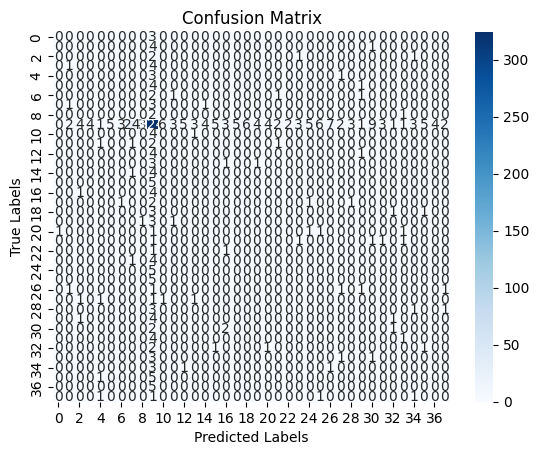

In [ ]:
evaluate_model(model_1, test_generator, model_name="Model 1")

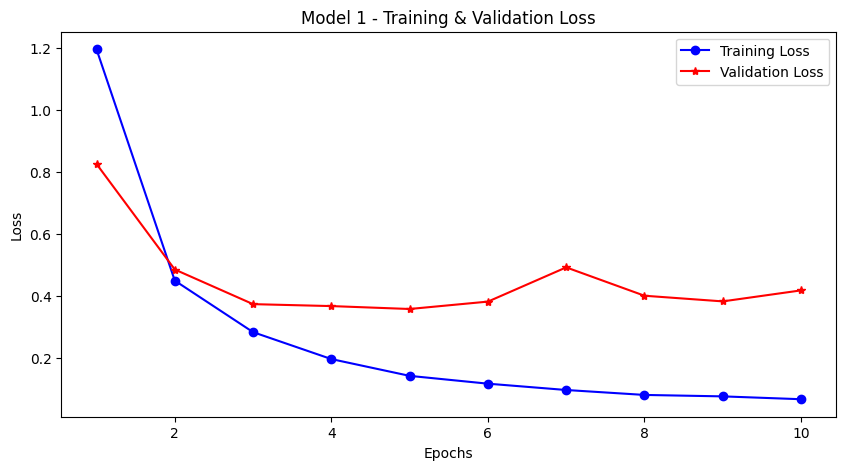

In [ ]:
# Plot loss curve & evaluate
loss_curve_plot(model_1, history_1, test_generator, model_name="Model 1")

In [ ]:
# Create an EarlyStopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Create and train the second model2 (RMSprop)
model_2 = define_model('RMSprop',l2(0.005),True, 0.5, 0.01)
history_2 = model_2.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=10,
   callbacks=[early_stopping],
  verbose=1
)

Epoch 1/10
1758/1758 ━━━━━━━━━━━━━━━━━━━━ 157s 89ms/step - accuracy: 0.3807 - loss: 2.2350 - val_accuracy: 0.7183 - val_loss: 0.9380
Epoch 2/10
1758/1758 ━━━━━━━━━━━━━━━━━━━━ 156s 89ms/step - accuracy: 0.8165 - loss: 0.5972 - val_accuracy: 0.8576 - val_loss: 0.4555
Epoch 3/10
1758/1758 ━━━━━━━━━━━━━━━━━━━━ 158s 90ms/step - accuracy: 0.8924 - loss: 0.3388 - val_accuracy: 0.8987 - val_loss: 0.3289
Epoch 4/10
1758/1758 ━━━━━━━━━━━━━━━━━━━━ 158s 90ms/step - accuracy: 0.9276 - loss: 0.2303 - val_accuracy: 0.8976 - val_loss: 0.3511
Epoch 5/10
1758/1758 ━━━━━━━━━━━━━━━━━━━━ 158s 90ms/step - accuracy: 0.9487 - loss: 0.1675 - val_accuracy: 0.8991 - val_loss: 0.3968
Epoch 6/10
1758/1758 ━━━━━━━━━━━━━━━━━━━━ 157s 89ms/step - accuracy: 0.9586 - loss: 0.1343 - val_accuracy: 0.9046 - val_loss: 0.4008



Evaluating Model 2...

21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step
Model 2 - Test Accuracy: 0.780, F1 Score: 0.3945, Recall: 0.3945, Precision: 0.3945
Model 'Model 2' saved successfully.

Confusion Matrix:
 [[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


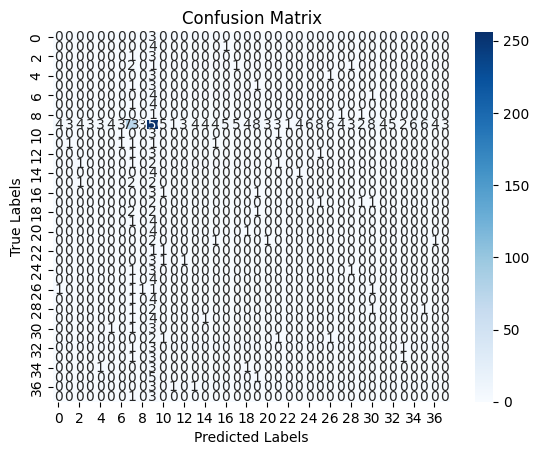

In [ ]:
evaluate_model(model_2, test_generator, model_name="Model 2")

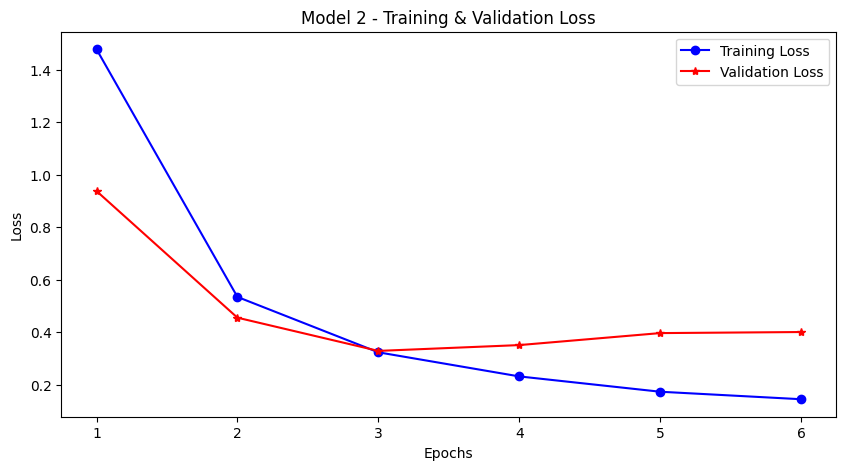

In [ ]:
loss_curve_plot(model_2, history_2, test_generator, model_name="Model 2")

In [ ]:
# Create and train the second model (SGD)
model_3 = define_model('Nadam',l1(0.05),False, 0.05,0.001)
history_3 = model_3.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=10,
    verbose=1
)

Epoch 1/10
1758/1758 ━━━━━━━━━━━━━━━━━━━━ 157s 89ms/step - accuracy: 0.5075 - loss: 1.7510 - val_accuracy: 0.8627 - val_loss: 0.4449
Epoch 2/10
1758/1758 ━━━━━━━━━━━━━━━━━━━━ 160s 91ms/step - accuracy: 0.8948 - loss: 0.3337 - val_accuracy: 0.8725 - val_loss: 0.4222
Epoch 3/10
1758/1758 ━━━━━━━━━━━━━━━━━━━━ 159s 91ms/step - accuracy: 0.9378 - loss: 0.1859 - val_accuracy: 0.8870 - val_loss: 0.3809
Epoch 4/10
1758/1758 ━━━━━━━━━━━━━━━━━━━━ 154s 88ms/step - accuracy: 0.9602 - loss: 0.1205 - val_accuracy: 0.9071 - val_loss: 0.3316
Epoch 5/10
1758/1758 ━━━━━━━━━━━━━━━━━━━━ 154s 88ms/step - accuracy: 0.9698 - loss: 0.0898 - val_accuracy: 0.8885 - val_loss: 0.4051
Epoch 6/10
1758/1758 ━━━━━━━━━━━━━━━━━━━━ 157s 89ms/step - accuracy: 0.9761 - loss: 0.0728 - val_accuracy: 0.8964 - val_loss: 0.4072
Epoch 7/10
1758/1758 ━━━━━━━━━━━━━━━━━━━━ 157s 89ms/step - accuracy: 0.9776 - loss: 0.0666 - val_accuracy: 0.9102 - val_loss: 0.3639
Epoch 8/10
1758/1758 ━━━━━━━━━━━━━━━━━━━━ 156s 89ms/step - accuracy: 


Evaluating Model 3...

21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step
Model 3 - Test Accuracy: 0.843, F1 Score: 0.4817, Recall: 0.4817, Precision: 0.4817
Model 'Model 3' saved successfully.

Confusion Matrix:
 [[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


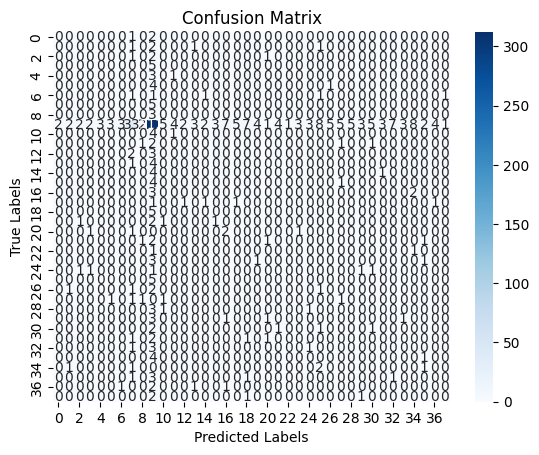

In [ ]:
evaluate_model(model_3, test_generator, model_name="Model 3")

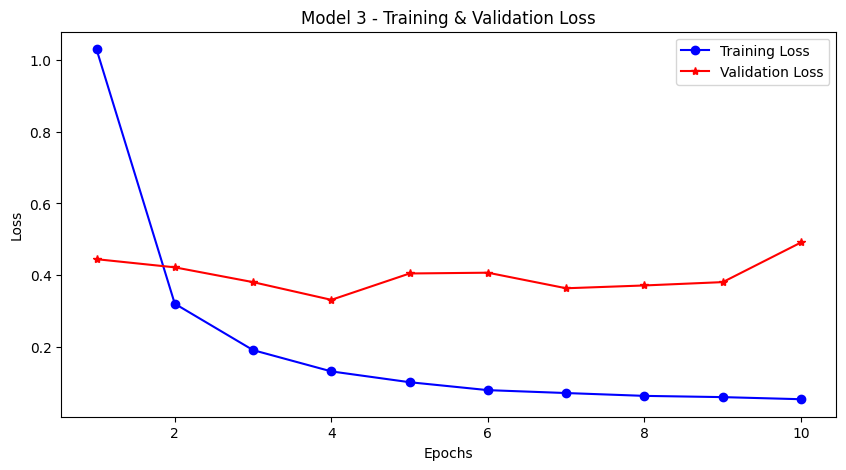

In [ ]:
loss_curve_plot(model_3, history_3, test_generator, model_name="Model 3")

In [ ]:
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

In [ ]:
model_4 = define_model('SGD',l2(0.005),True, 0.5,0.01)

/Users/samenergy/Library/Python/3.9/lib/python/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
# Create and train the fourth model
history_4 = model_4.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=10,
    callbacks=[early_stopping],
    verbose=1
)

Epoch 1/10
1758/1758 ━━━━━━━━━━━━━━━━━━━━ 158s 90ms/step - accuracy: 0.1039 - loss: 3.3354 - val_accuracy: 0.4991 - val_loss: 1.7110
Epoch 2/10
1758/1758 ━━━━━━━━━━━━━━━━━━━━ 157s 90ms/step - accuracy: 0.5511 - loss: 1.5214 - val_accuracy: 0.7143 - val_loss: 0.9441
Epoch 3/10
1758/1758 ━━━━━━━━━━━━━━━━━━━━ 159s 91ms/step - accuracy: 0.7401 - loss: 0.8424 - val_accuracy: 0.8088 - val_loss: 0.6266
Epoch 4/10
1758/1758 ━━━━━━━━━━━━━━━━━━━━ 162s 92ms/step - accuracy: 0.8276 - loss: 0.5504 - val_accuracy: 0.8336 - val_loss: 0.5641
Epoch 5/10
1758/1758 ━━━━━━━━━━━━━━━━━━━━ 161s 92ms/step - accuracy: 0.8783 - loss: 0.3889 - val_accuracy: 0.8592 - val_loss: 0.4610
Epoch 6/10
1758/1758 ━━━━━━━━━━━━━━━━━━━━ 158s 90ms/step - accuracy: 0.9106 - loss: 0.2838 - val_accuracy: 0.8733 - val_loss: 0.4047
Epoch 7/10
1758/1758 ━━━━━━━━━━━━━━━━━━━━ 159s 90ms/step - accuracy: 0.9296 - loss: 0.2183 - val_accuracy: 0.8839 - val_loss: 0.3686
Epoch 8/10
1758/1758 ━━━━━━━━━━━━━━━━━━━━ 164s 93ms/step - accuracy: 


Evaluating Model 4...

21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step
Model 4 - Test Accuracy: 0.939, F1 Score: 0.5015, Recall: 0.5015, Precision: 0.5015
Model 'Model 4' saved successfully.

Confusion Matrix:
 [[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


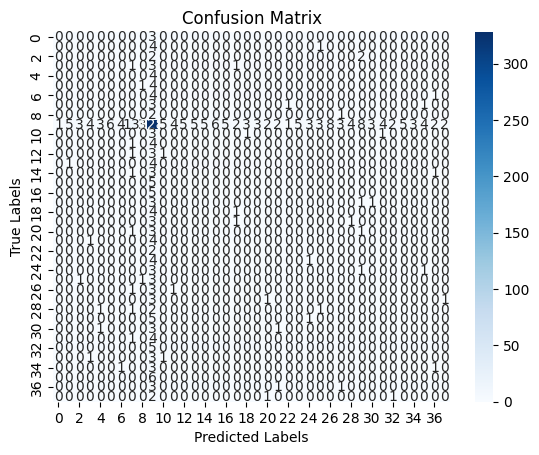

In [ ]:
evaluate_model(model_4, test_generator, model_name="Model 4")

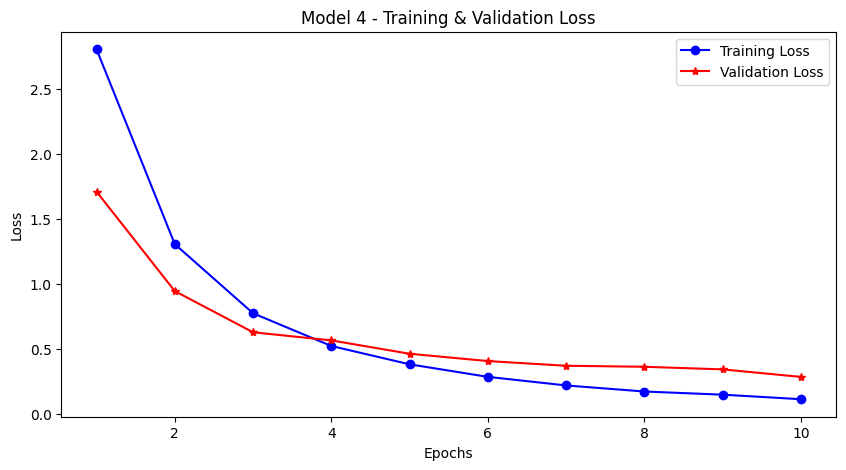

In [ ]:
loss_curve_plot(model_4, history_4, test_generator, model_name="Model 4")

In [ ]:
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

In [ ]:
model_5 = define_model('adam',l2(0.005),True, 0.5,0.001)

In [ ]:
# Create and train the fourth model
history_5 = model_5.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=15,
    callbacks=[early_stopping],
    verbose=1
)

Epoch 1/15


/Users/samenergy/Library/Python/3.9/lib/python/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


1758/1758 ━━━━━━━━━━━━━━━━━━━━ 170s 96ms/step - accuracy: 0.3995 - loss: 2.1198 - val_accuracy: 0.7632 - val_loss: 0.7573
Epoch 2/15
1758/1758 ━━━━━━━━━━━━━━━━━━━━ 171s 97ms/step - accuracy: 0.8133 - loss: 0.6036 - val_accuracy: 0.8419 - val_loss: 0.5046
Epoch 3/15
1758/1758 ━━━━━━━━━━━━━━━━━━━━ 175s 99ms/step - accuracy: 0.8793 - loss: 0.3756 - val_accuracy: 0.8573 - val_loss: 0.4528
Epoch 4/15
1758/1758 ━━━━━━━━━━━━━━━━━━━━ 177s 101ms/step - accuracy: 0.9076 - loss: 0.2807 - val_accuracy: 0.8759 - val_loss: 0.4005
Epoch 5/15
1758/1758 ━━━━━━━━━━━━━━━━━━━━ 181s 103ms/step - accuracy: 0.9324 - loss: 0.2102 - val_accuracy: 0.8834 - val_loss: 0.3897
Epoch 6/15
1758/1758 ━━━━━━━━━━━━━━━━━━━━ 179s 102ms/step - accuracy: 0.9452 - loss: 0.1660 - val_accuracy: 0.8922 - val_loss: 0.3913
Epoch 7/15
1758/1758 ━━━━━━━━━━━━━━━━━━━━ 178s 101ms/step - accuracy: 0.9547 - loss: 0.1304 - val_accuracy: 0.8831 - val_loss: 0.4222
Epoch 8/15
1758/1758 ━━━━━━━━━━━━━━━━━━━━ 177s 100ms/step - accuracy: 0.9593


Evaluating Model 5...



/Users/samenergy/Library/Python/3.9/lib/python/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step
Model 5 - Test Accuracy: 0.887, F1 Score: 0.4878, Recall: 0.4878, Precision: 0.4878
Model 'Model 5' saved successfully.

Confusion Matrix:
 [[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 1 0 ... 0 0 0]
 ...
 [0 0 0 ... 1 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


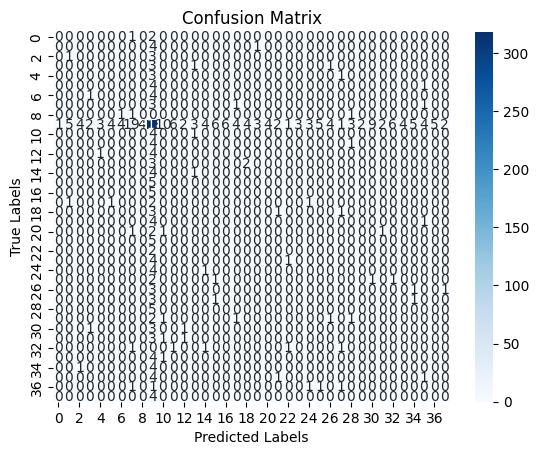

In [ ]:
evaluate_model(model_5, test_generator, model_name="Model 5")

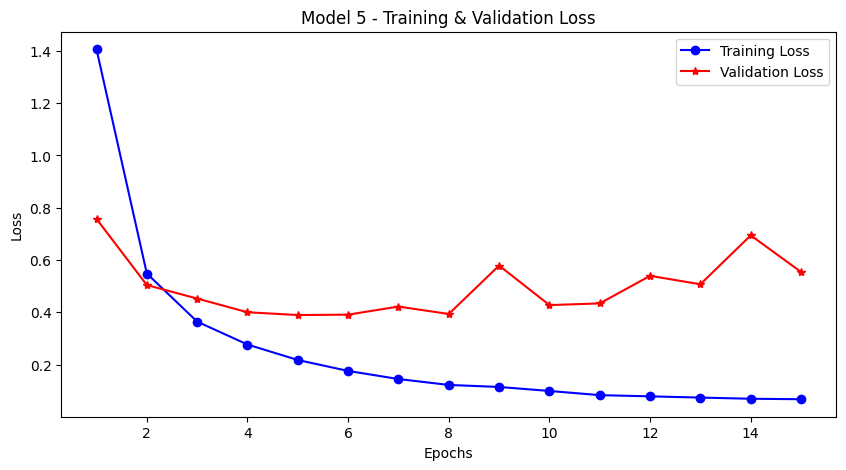

In [ ]:
loss_curve_plot(model_5, history_5, test_generator, model_name="Model 5")

In [ ]:
# Extract features for Classical ML Models
def extract_features(generator):
    features = []
    labels = []
    for batch in generator:
        batch_features, batch_labels = batch
        batch_features = batch_features.reshape(batch_features.shape[0], -1)  # Flatten images
        features.extend(batch_features)
        labels.extend(np.argmax(batch_labels, axis=1))  # Convert one-hot to class labels
        if len(features) >= generator.samples:  # Stop after processing all images
            break
    return np.array(features), np.array(labels)


In [ ]:
X_train, y_train = extract_features(train_generator)
X_val, y_val = extract_features(validation_generator)
X_test, y_test = extract_features(test_generator)

In [ ]:
# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

In [ ]:
# Train Logistic Regression
logistic_model = LogisticRegression(max_iter=1000)
logistic_model.fit(X_train_scaled, y_train)
y_pred_logistic = logistic_model.predict(X_test_scaled)

In [ ]:
# Evaluate Logistic Regression
cm_logistic = confusion_matrix(y_test, y_pred_logistic)
accuracy_logistic = accuracy_score(y_test, y_pred_logistic)
f1_logistic = f1_score(y_test, y_pred_logistic, average='micro')
recall_logistic = recall_score(y_test, y_pred_logistic, average='micro')
precision_logistic = precision_score(y_test, y_pred_logistic, average='micro')

print("\nLogistic Regression - Test Metrics:")
print(f"Accuracy: {accuracy_logistic:.4f}")
print(f"F1 Score: {f1_logistic:.4f}")
print(f"Recall: {recall_logistic:.4f}")
print(f"Precision: {precision_logistic:.4f}")


Logistic Regression - Test Metrics:
Accuracy: 0.6239
F1 Score: 0.6239
Recall: 0.6239
Precision: 0.6239


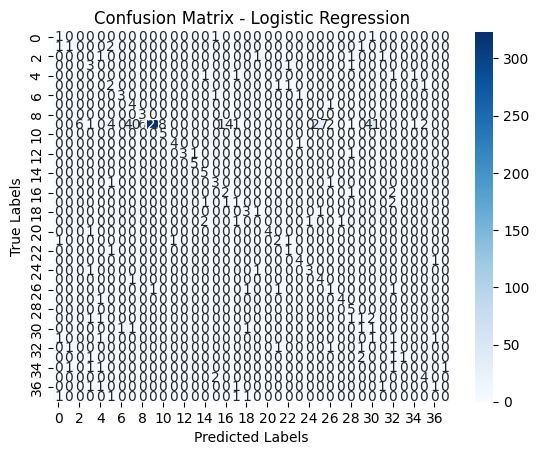

In [ ]:
sns.heatmap(cm_logistic, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix - Logistic Regression')
plt.show()

In [ ]:
# Train SVM
svm_model = SVC(kernel='linear', C=1.0)
svm_model.fit(X_train_scaled, y_train)
y_pred_svm = svm_model.predict(X_test_scaled)

In [ ]:
# Evaluate SVM
cm_svm = confusion_matrix(y_test, y_pred_svm)
f1_svm = f1_score(y_test, y_pred_svm, average='micro')
recall_svm = recall_score(y_test, y_pred_svm, average='micro')
precision_svm = precision_score(y_test, y_pred_svm, average='micro')
accuracy_svm = accuracy_score(y_test, y_pred_svm)

print("\nSVM - Test Metrics:")
print(f"Accuracy: {accuracy_svm:.4f}")
print(f"F1 Score: {f1_svm:.4f}, Recall: {recall_svm:.4f}, Precision: {precision_svm:.4f}")



SVM - Test Metrics:
Accuracy: 0.7584
F1 Score: 0.7584, Recall: 0.7584, Precision: 0.7584


In [ ]:
# Save the trained SVM model
joblib.dump(svm_model, 'svm_model.pkl')

print("SVM model saved successfully as 'svm_model.pkl'.")


SVM model saved successfully as 'svm_model.pkl'.


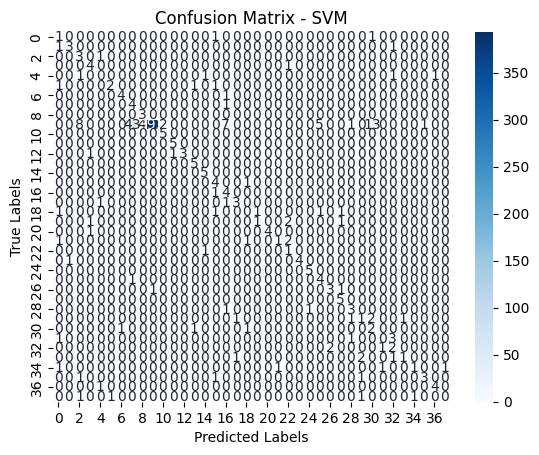

In [ ]:
sns.heatmap(cm_svm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix - SVM')
plt.show()

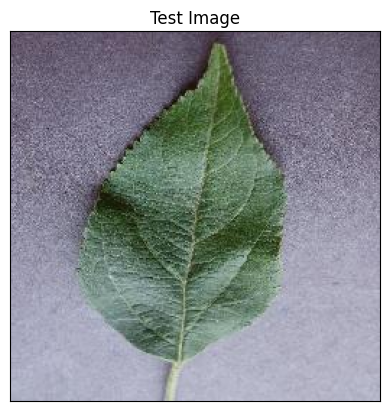

(1, 128, 128, 3)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Predicted class index: 3
Predicted Disease: Apple___healthy


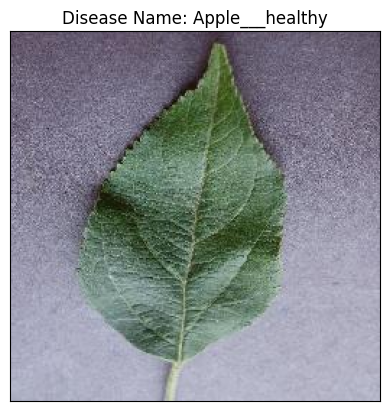

In [ ]:


model = tf.keras.models.load_model('/Users/samenergy/Downloads/Plant_Disease_Dataset/Model 4.keras')

image_path = "/Users/samenergy/Downloads/Plant_Disease_Dataset/test/Apple___healthy/0adc1c5b-8958-47c0-a152-f28078c214f1___RS_HL 7825.JPG"

img = cv2.imread(image_path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

plt.imshow(img)
plt.title("Test Image")
plt.xticks([])
plt.yticks([])
plt.show()

image = tf.keras.preprocessing.image.load_img(image_path, target_size=(128, 128))
input_arr = tf.keras.preprocessing.image.img_to_array(image)
input_arr = np.expand_dims(input_arr, axis=0)
input_arr = input_arr / 255.0

print(input_arr.shape)


prediction = model.predict(input_arr)
prediction, prediction.shape

result_index = np.argmax(prediction)
print(f"Predicted class index: {result_index}")

class_name = [
    'Apple___Apple_scab',
    'Apple___Black_rot',
    'Apple___Cedar_apple_rust',
    'Apple___healthy',
    'Blueberry___healthy',
    'Cherry_(including_sour)___healthy',
    'Cherry_(including_sour)___Powdery_mildew',
    'Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot',
    'Corn_(maize)___Common_rust_',
    'Corn_(maize)___healthy',
    'Corn_(maize)___Northern_Leaf_Blight',
    'Grape___Black_rot',
    'Grape___Esca_(Black_Measles)',
    'Grape___healthy',
    'Grape___Leaf_blight_(Isariopsis_Leaf_Spot)',
    'Orange___Haunglongbing_(Citrus_greening)',
    'Peach___Bacterial_spot',
    'Peach___healthy',
    'Pepper,_bell___Bacterial_spot',
    'Pepper,_bell___healthy',
    'Potato___Early_blight',
    'Potato___healthy',
    'Potato___Late_blight',
    'Raspberry___healthy',
    'Soybean___healthy',
    'Squash___Powdery_mildew',
    'Strawberry___healthy',
    'Strawberry___Leaf_scorch',
    'Tomato___Bacterial_spot',
    'Tomato___Early_blight',
    'Tomato___healthy',
    'Tomato___Late_blight',
    'Tomato___Leaf_Mold',
    'Tomato___Septoria_leaf_spot',
    'Tomato___Spider_mites Two-spotted_spider_mite',
    'Tomato___Target_Spot',
    'Tomato___Tomato_mosaic_virus',
    'Tomato___Tomato_Yellow_Leaf_Curl_Virus'
]

model_prediction = class_name[result_index]
print(f"Predicted Disease: {model_prediction}")

plt.imshow(img)
plt.title(f"Disease Name: {model_prediction}")
plt.xticks([])
plt.yticks([])
plt.show()
